<a href="https://colab.research.google.com/github/lazzarusd/Coursera_Capstone/blob/master/The_Battle_of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find the best place to open a Restaurant
### In a city of your choice, if someone is looking to open a restaurant, where would you recommend that they open it? Similarly, if a contractor is trying to start their own business, where would you recommend that they setup their office?

### To create the dataframe I decided to use the wikipedia Python API. It's very easy to get the pandas dataframe.

In [1]:
!pip install wikipedia
!pip install folium
!pip install geopy
!pip install geopandas

  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp36-none-any.whl size=11686 sha256=d7ef5462291a92f95654610afa7fff8a675705da569c4845969a016f9c1adbef
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia
     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 16.4MB/s 
     |████████████████████████████████| 14.7MB 310kB/s 


In [2]:
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import wikipedia as wp
import requests
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopandas as gpd

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

print('Libraries imported.')

Libraries imported.


In [171]:
wp.set_lang("it")
html = wp.page("Municipi_di_Milano").html()

milan_borough_wiki = pd.read_html(html)[3]

milan_borough_wiki['#'] = milan_borough_wiki['#'].str.replace('Municipio ', '')

milan_borough_wiki.columns = ('Borough', 'Name', 'Area(km2)', 'Population(31/12/2018)', 'Population_Density(km2)', 'Neighborhood', 'Localizzazione')

milan_borough_wiki.drop(columns=["Localizzazione"], inplace=True)
milan_borough_wiki.drop(columns=["Neighborhood"], inplace=True)
milan_borough_wiki.drop(milan_borough_wiki.tail(1).index, inplace=True)

# milan_borough.set_index('Borough', inplace=True)
milan_borough_wiki

,Borough,Name,Area(km2),Population(31/12/2018),Population_Density(km2)
0,1,Centro storico,967,98 531,10 189
1,2,"Stazione Centrale, Gorla, Turro, Greco, Cresce...",1258,162 090,12 884
2,3,"Città Studi, Lambrate, Venezia",1423,144 110,10 127
3,4,"Vittoria, Forlanini",2095,161 551,7 711
4,5,"Vigentino, Chiaravalle, Gratosoglio",2987,126 089,4 221
5,6,"Barona, Lorenteggio",1828,151 291,8 276
6,7,"Baggio, De Angeli, San Siro",3134,175 465,5 598
7,8,"Fiera, Gallaratese, Quarto Oggiaro",2372,188 367,7 941
8,9,"Stazione Garibaldi, Niguarda",2112,187 773,8 890


In [172]:
geo_list = []

for x in range(1,10):
    page = requests.get('https://en.wikipedia.org/wiki/Zone_' + str(x) + '_of_Milan')
    el = BeautifulSoup(page.content, 'html.parser').find(id='coordinates').find('span', class_='geo')
    geo_list.append(el.text.split("; "))

lat, lon = zip(*geo_list)

milan_borough_wiki['Latitude'] = lat
milan_borough_wiki['Longitude'] = lon
milan_borough_wiki

,Borough,Name,Area(km2),Population(31/12/2018),Population_Density(km2),Latitude,Longitude
0,1,Centro storico,967,98 531,10 189,45.471282,9.184999
1,2,"Stazione Centrale, Gorla, Turro, Greco, Cresce...",1258,162 090,12 884,45.486117,9.203635
2,3,"Città Studi, Lambrate, Venezia",1423,144 110,10 127,45.482506,9.241047
3,4,"Vittoria, Forlanini",2095,161 551,7 711,45.431573,9.244738
4,5,"Vigentino, Chiaravalle, Gratosoglio",2987,126 089,4 221,45.416987,9.238333
5,6,"Barona, Lorenteggio",1828,151 291,8 276,45.440087,9.155924
6,7,"Baggio, De Angeli, San Siro",3134,175 465,5 598,45.461244,9.089917
7,8,"Fiera, Gallaratese, Quarto Oggiaro",2372,188 367,7 941,45.515925,9.140196
8,9,"Stazione Garibaldi, Niguarda",2112,187 773,8 890,45.516888,9.191866


In [173]:
url = 'https://raw.githubusercontent.com/lazzarusd/Coursera_Capstone/master/file/Milano_Municipi_NIL.csv'
milan_borough = pd.read_csv(url)
milan_borough.rename(columns={"NIL": "Neighborhood", "Municipio": "Borough"}, inplace=True)
milan_borough.head()

,Neighborhood,Borough
0,01. Duomo,1
1,02. Brera,1
2,03. Giardini Porta Venezia,1
3,04. Guastalla,1
4,05. Porta Vigentina - Porta Lodovica,5


In [174]:
milan_borough['Borough'] = milan_borough['Borough'].astype(int)
milan_borough_wiki['Borough'] = milan_borough_wiki['Borough'].astype(int)

milan_borough = pd.merge(milan_borough, milan_borough_wiki, on='Borough')
milan_borough.head()

,Neighborhood,Borough,Name,Area(km2),Population(31/12/2018),Population_Density(km2),Latitude,Longitude
0,01. Duomo,1,Centro storico,967,98 531,10 189,45.471282,9.184999
1,02. Brera,1,Centro storico,967,98 531,10 189,45.471282,9.184999
2,03. Giardini Porta Venezia,1,Centro storico,967,98 531,10 189,45.471282,9.184999
3,04. Guastalla,1,Centro storico,967,98 531,10 189,45.471282,9.184999
4,07. Magenta- San Vittore,1,Centro storico,967,98 531,10 189,45.471282,9.184999


In [9]:
milan_neighborhood_geodf = gpd.read_file('https://dati.comune.milano.it/dataset/e8e765fc-d882-40b8-95d8-16ff3d39eb7c/resource/9c4e0776-56fc-4f3d-8a90-f4992a3be426/download/ds964_nil_wm.geojson')
milan_neighborhood_geodf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(88, 9)


,ID_NIL,NIL,Valido_dal,Valido_al,Fonte,Shape_Length,Shape_Area,OBJECTID,geometry
0,48,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,8723.368714,2.406306e+06,89,"POLYGON ((9.15422 45.43775, 9.15274 45.43887, ..."
1,64,TRENNO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,3309.998800,4.896921e+05,90,"POLYGON ((9.10623 45.49016, 9.10591 45.49084, ..."
2,67,PORTELLO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,3800.750663,9.096022e+05,91,"POLYGON ((9.15636 45.48785, 9.15495 45.48852, ..."
3,81,BOVISASCA,05/02/2020,Vigente,Milano 2030 - PGT Approvato,7105.469715,1.578028e+06,92,"POLYGON ((9.16803 45.52234, 9.16763 45.52272, ..."
4,84,PARCO NORD,05/02/2020,Vigente,Milano 2030 - PGT Approvato,11741.717005,1.532331e+06,93,"POLYGON ((9.20040 45.52848, 9.20028 45.52846, ..."


In [10]:
milan_neighborhood = milan_neighborhood_geodf[['ID_NIL', 'NIL']].copy()
milan_neighborhood.columns = ('Id', 'Neighborhood')
milan_neighborhood.tail()

(88, 2)


,Id,Neighborhood
83,68,PAGANO
84,2,BRERA
85,33,ROGOREDO - SANTA GIULIA
86,17,ADRIANO
87,53,LORENTEGGIO


In [11]:
from shapely.wkt import loads as load_wkt

centroid_list = []

for polygon in milan_neighborhood_geodf["geometry"]:
    box_str = str(polygon)
    p1 = load_wkt(box_str)
    point = p1.centroid
#     print(type(p1.centroid.x))
#     print(p1.centroid.y)
    centroid_list.append((p1.centroid.y, p1.centroid.x))

lat_centr, lon_centr = zip(*centroid_list)

milan_neighborhood['Latitude'] = lat_centr
milan_neighborhood['Longitude'] = lon_centr
milan_neighborhood.head()

,Id,Neighborhood,Latitude,Longitude
0,48,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.438460,9.137260
1,64,TRENNO,45.492822,9.101675
2,67,PORTELLO,45.484490,9.153947
3,81,BOVISASCA,45.517433,9.156731
4,84,PARCO NORD,45.523514,9.184235


In [166]:
milan_borough.head()

,NIL,Municipio
0,01. Duomo,1
1,02. Brera,1
2,03. Giardini Porta Venezia,1
3,04. Guastalla,1
4,05. Porta Vigentina - Porta Lodovica,5


In [176]:
new_list = []

for ind1, neighborhood in milan_neighborhood.iterrows():
    for ind2, borough in milan_borough.iterrows():
        s1 = neighborhood[["Neighborhood"]].item().lower().partition(' - ')[0]
        s2 = borough[["Neighborhood"]].item().lower()
#         print(str(type(s1)) + ": " + s1 + " # " + str(type(s2)) + ": " + s2)
        if s1 in s2:
            frame = {'Id': neighborhood[["Id"]].item(), 
                     'Neighborhood': neighborhood[["Neighborhood"]].item(),
                     'Borough': borough[["Borough"]].item(),
                     'Population(31/12/2018) Borough': borough[["Population(31/12/2018)"]].item(),
                     'Latitude': neighborhood[["Latitude"]].item(),
                     'Longitude': neighborhood[["Longitude"]].item()
                    }
            new_list.append(frame)

cn = ['Id', 'Neighborhood', 'Borough', 'Population(31/12/2018) Borough', 'Latitude', 'Longitude']
df_milan_complete = pd.DataFrame(new_list, columns = cn)
df_milan_complete.head()

,Id,Neighborhood,Borough,Population(31/12/2018) Borough,Latitude,Longitude
0,48,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,6,151 291,45.438460,9.137260
1,64,TRENNO,8,188 367,45.492822,9.101675
2,67,PORTELLO,8,188 367,45.484490,9.153947
3,81,BOVISASCA,9,187 773,45.517433,9.156731
4,84,PARCO NORD,9,187 773,45.523514,9.184235


### Create map of milan using latitude and longitude values 
#### Understand better the data

In [177]:
address = 'Milan, MI'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Milan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Milan are 45.4668, 9.1905.


In [178]:
map_milan = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_milan_complete['Latitude'], df_milan_complete['Longitude'], df_milan_complete['Id'], df_milan_complete['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan)  
    
map_milan

### Use foursquare API to check the places in milan

In [16]:
# @hidden_cell

CLIENT_ID = 'CPAC2GRN3VCADF3FNWJAPLQYMNICM0YBUAGHFXMZEGRZXDPG' # your Foursquare ID
CLIENT_SECRET = 'LOH4RGLND40CSDX10KBUTD2OV3GQN3DJXCTIPO54DTNDI4UW' # your Foursquare Secret
VERSION = '20200605'
LIMIT = 100

In [28]:
radius = 1000
df_milan_complete.loc[11, 'Neighborhood']

neighborhood_latitude = df_milan_complete.loc[11, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_milan_complete.loc[11, 'Longitude'] # neighborhood longitude value
neighborhood_name = df_milan_complete.loc[11, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url

Latitude and longitude values of DUOMO are 45.46370717900563, 9.186948292279983.


'https://api.foursquare.com/v2/venues/explore?&client_id=CPAC2GRN3VCADF3FNWJAPLQYMNICM0YBUAGHFXMZEGRZXDPG&client_secret=LOH4RGLND40CSDX10KBUTD2OV3GQN3DJXCTIPO54DTNDI4UW&v=20200605&ll=45.46370717900563,9.186948292279983&radius=1000&limit=100'

### Create a function that extracts the category of the venue

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Extract venues for each neighborhood in Milan

In [30]:
def getNeighborhoodVenues(latitude, longitude, neighborhood, radius):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)
        
        resp = requests.get(url).json()["response"]
        
        if "groups" in resp:
            # make the GET request
            results = resp['groups'][0]['items']
            # return only relevant information for each nearby venue
            for venue in results:
                venues.append((
                    neighborhood,
                    lat, 
                    long, 
                    venue['venue']['name'], 
                    venue['venue']['id'], 
                    venue['venue']['location']['lat'], 
                    venue['venue']['location']['lng'],  
                    venue['venue']['location']['distance'],  
                    venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
    
    return venues 

milan_venues = getNeighborhoodVenues(df_milan_complete['Latitude'], df_milan_complete['Longitude'], df_milan_complete['Neighborhood'], radius)
print('There are {} unique venue categories. Some of them are as below:'.format(len(milan_venues['VenueCategory'].unique())))
milan_venues.head()

There are 283 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Mio,4c1bd57663750f476e8cb567,45.442099,9.132717,538,Italian Restaurant
1,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Osteria Ma.Si.,4ca8d32fb7106dcb708f76a5,45.444339,9.140705,707,Italian Restaurant
2,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Lungolanotte,4bbf1ed930c99c7428a05411,45.442546,9.133911,524,Italian Restaurant
3,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Ittolitos,4c41851eda3dc9286506c9b9,45.440443,9.146048,721,Pub
4,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Football City,4c86a842d8086dcbe2609c52,45.443407,9.130824,745,Soccer Field


In [31]:
print(milan_venues.shape)
milan_venues.head()

(4004, 9)


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Mio,4c1bd57663750f476e8cb567,45.442099,9.132717,538,Italian Restaurant
1,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Osteria Ma.Si.,4ca8d32fb7106dcb708f76a5,45.444339,9.140705,707,Italian Restaurant
2,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Lungolanotte,4bbf1ed930c99c7428a05411,45.442546,9.133911,524,Italian Restaurant
3,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Ittolitos,4c41851eda3dc9286506c9b9,45.440443,9.146048,721,Pub
4,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Football City,4c86a842d8086dcbe2609c52,45.443407,9.130824,745,Soccer Field


In [32]:
print('Top 10 distinct venue counts are as below')
milan_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:100]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Italian Restaurant,271
Pizza Place,171
Café,155
Hotel,106
Ice Cream Shop,81
Supermarket,73
Restaurant,68
Plaza,65
Tram Station,65


In [33]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place','Italian Restaurant']
vegan_restaurant_list = ['Vegetarian / Vegan Restaurant']

# Filter restaurants 
    
milan_venues['RestFlag']=False
for restCat in restaurant_list:
    milan_venues['RestFlag'] = milan_venues['RestFlag'] | milan_venues['VenueCategory'].str.contains(restCat)
    
milan_restaurants = milan_venues[milan_venues['RestFlag'] == True].iloc[:,:-1]
vegan_restaurants = milan_restaurants[ milan_restaurants['VenueCategory'].isin(vegan_restaurant_list) ]
other_restaurants = milan_restaurants[ ~milan_restaurants['VenueCategory'].isin(vegan_restaurant_list) ]

print('Total number of restaurants:', len(milan_restaurants['VenueId'].unique()))
print('Total number of vegan restaurants:', len(vegan_restaurants['VenueId'].unique()))
print('Percentage of vegan restaurants: {:.2f}%'.format(len(vegan_restaurants['VenueId'].unique()) / len(milan_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 1007
Total number of vegan restaurants: 9
Percentage of vegan restaurants: 0.89%


59 neighborhoods do not have any vegan restaurant


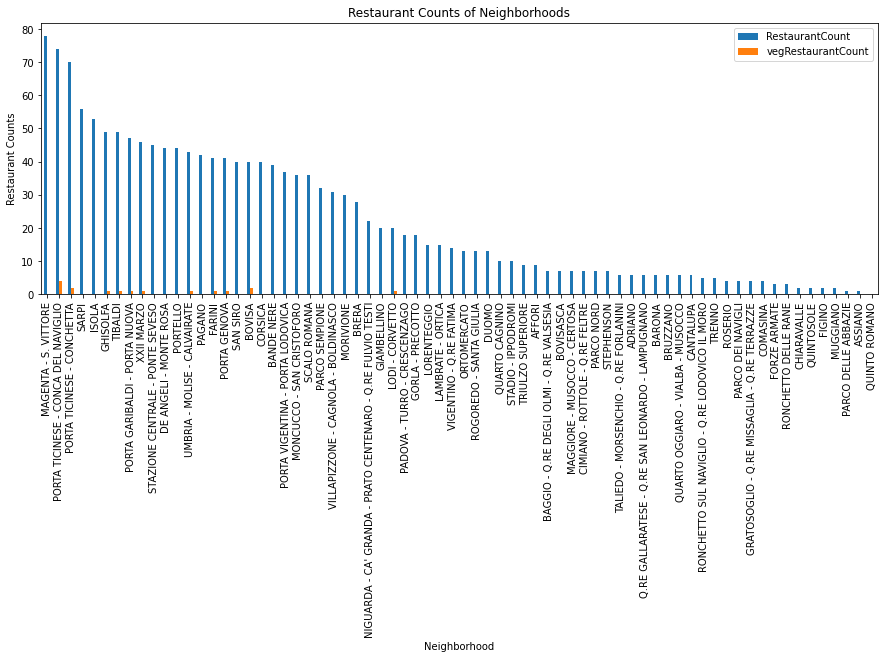

In [34]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  milan_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(milan_venues['Neighborhood']) - set(milan_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of vegan restaurants in each Neighborhood
df_veg_rest_counts =  vegan_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "vegRestaurantCount"})[['vegRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(milan_venues['Neighborhood']) - set(vegan_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_veg_rest_counts = df_veg_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'vegRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_veg_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_veg_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any vegan restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','vegRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

In [35]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(milan_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,4c1bd57663750f476e8cb567,8.2,15.0
1,4ca8d32fb7106dcb708f76a5,8.2,24.0
2,4bbf1ed930c99c7428a05411,7.6,11.0
3,4eb6d43f61af0dda90f2637a,NaN,NaN
4,570f376d498ef984430aaf6c,NaN,NaN


In [36]:
#merge raitings to restaurants 
milan_restaurants = milan_restaurants.merge(restaurants_raitings)
milan_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.438460,9.137260,Mio,4c1bd57663750f476e8cb567,45.442099,9.132717,538,Italian Restaurant,8.2,15.0
1,GIAMBELLINO,45.447062,9.136927,Mio,4c1bd57663750f476e8cb567,45.442099,9.132717,642,Italian Restaurant,8.2,15.0
2,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.438460,9.137260,Osteria Ma.Si.,4ca8d32fb7106dcb708f76a5,45.444339,9.140705,707,Italian Restaurant,8.2,24.0
3,GIAMBELLINO,45.447062,9.136927,Osteria Ma.Si.,4ca8d32fb7106dcb708f76a5,45.444339,9.140705,423,Italian Restaurant,8.2,24.0
4,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.438460,9.137260,Lungolanotte,4bbf1ed930c99c7428a05411,45.442546,9.133911,524,Italian Restaurant,7.6,11.0


In [37]:
#merge raitings to vegan restaurants 
vegan_restaurants = vegan_restaurants.merge(restaurants_raitings)
vegan_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,TIBALDI,45.440348,9.180459,La Susina,4cbe79a000d8370439de3d5c,45.448906,9.177723,976,Vegetarian / Vegan Restaurant,7.3,15.0
1,PORTA TICINESE - CONCA DEL NAVIGLIO,45.450475,9.181311,La Susina,4cbe79a000d8370439de3d5c,45.448906,9.177723,330,Vegetarian / Vegan Restaurant,7.3,15.0
2,PORTA TICINESE - CONCA DEL NAVIGLIO,45.450475,9.181311,La Susina,4cbe79a000d8370439de3d5c,45.448906,9.177723,330,Vegetarian / Vegan Restaurant,7.3,15.0
3,FARINI,45.493963,9.174605,Mens@sana,4ed149d729c223f929f25da5,45.490061,9.164685,887,Vegetarian / Vegan Restaurant,7.2,7.0
4,GHISOLFA,45.491002,9.162986,Mens@sana,4ed149d729c223f929f25da5,45.490061,9.164685,169,Vegetarian / Vegan Restaurant,7.2,7.0


In [179]:
milan_center = [latitude, longitude]
map_restaurant = folium.Map(location=milan_center, zoom_start=12)
df_milan_complete_novegRest = df_milan_complete[df_milan_complete['Neighborhood'].isin(noRestList)]

map_restaurant = folium.Map(location=milan_center, zoom_start=12) 

# Ensure you're handing it floats
milan_restaurants['VenueLatitude'] = milan_restaurants['VenueLatitude'].astype(float)
milan_restaurants['VenueLongitude'] = milan_restaurants['VenueLongitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = milan_restaurants[['VenueLatitude', 'VenueLongitude']]
heat_df = heat_df.dropna(axis=0, subset=['VenueLatitude','VenueLongitude'])

# List comprehension to make out list of lists
heat_data = [[row['VenueLatitude'],row['VenueLongitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_restaurant)

folium.Marker(milan_center).add_to(map_milan)
folium.Circle(milan_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=10000, fill=False, color='black').add_to(map_restaurant)

for lat, lon, neig, name in zip(vegan_restaurants['VenueLatitude'], vegan_restaurants['VenueLongitude'], vegan_restaurants['Neighborhood'], vegan_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = vegan_restaurants[vegan_restaurants['VenueRating'] < 7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)

map_restaurant

In [180]:
milan_center = [latitude, longitude]
map_restaurant= folium.Map(location=milan_center, zoom_start=12)

df_milan_complete_novegRest = df_milan_complete[df_milan_complete['Neighborhood'].isin(noRestList)]

map_restaurant = folium.Map(location=milan_center, zoom_start=12) 

# Ensure you're handing it floats
milan_restaurants['VenueLatitude'] = milan_restaurants['VenueLatitude'].astype(float)
milan_restaurants['VenueLongitude'] = milan_restaurants['VenueLongitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = milan_restaurants[['VenueLatitude', 'VenueLongitude']]
heat_df = heat_df.dropna(axis=0, subset=['VenueLatitude','VenueLongitude'])

# List comprehension to make out list of lists
heat_data = [[row['VenueLatitude'],row['VenueLongitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_restaurant)

folium.Marker(milan_center).add_to(map_milan)
folium.Circle(milan_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(milan_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_milan_complete_novegRest['Latitude'], df_milan_complete_novegRest['Longitude'], df_milan_complete_novegRest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)

map_restaurant

# Clustering

In [181]:
milan_venues.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,RestFlag
0,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Mio,4c1bd57663750f476e8cb567,45.442099,9.132717,538,Italian Restaurant,True
1,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Osteria Ma.Si.,4ca8d32fb7106dcb708f76a5,45.444339,9.140705,707,Italian Restaurant,True
2,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Lungolanotte,4bbf1ed930c99c7428a05411,45.442546,9.133911,524,Italian Restaurant,True
3,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Ittolitos,4c41851eda3dc9286506c9b9,45.440443,9.146048,721,Pub,False
4,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Football City,4c86a842d8086dcbe2609c52,45.443407,9.130824,745,Soccer Field,False


In [127]:
# # one hot encoding
# onehot = pd.get_dummies(milan_venues[['VenueCategory']], prefix="", prefix_sep="")
# # add neighborhood column back to dataframe
# onehot['Neighborhood'] = milan_venues['Neighborhood']

# milan_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# # move neighborhood column to the first column and filter only restaurant columns 
# fixed_columns =['Neighborhood'] + list(milan_venues['VenueCategory'].unique())
# milan_grouped = milan_grouped[fixed_columns]

# print("{}  neighborhoods' venue category are shown in {} columns as below".format(milan_grouped.shape[0],milan_grouped.shape[1]-1))
# milan_grouped.head()

# one hot encoding
milan_onehot = pd.get_dummies(milan_venues[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
milan_onehot['Neighborhood'] = milan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [milan_onehot.columns[-1]] + list(milan_onehot.columns[:-1])
milan_onehot = milan_onehot[fixed_columns]

milan_onehot.head()

,Women's Store,Abruzzo Restaurant,Accessories Store,Adult Education Center,African Restaurant,Airport,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Ballroom,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campanian Restaurant,Campground,Canal,Candy Store,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Doner Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Lingerie Store,Lombard Restaurant,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Piadineria,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Puglia Restaurant,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,Rock Club,Roman Restaurant,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sardinian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Sicilian Restaurant,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stadium,Stationery Store,Steakhouse,Street Art,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water 

In [129]:
milan_grouped = milan_onehot.groupby('Neighborhood').sum().reset_index()
milan_grouped.head()

,Neighborhood,Women's Store,Abruzzo Restaurant,Accessories Store,Adult Education Center,African Restaurant,Airport,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Ballroom,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campanian Restaurant,Campground,Canal,Candy Store,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dog Run,Doner Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Lingerie Store,Lombard Restaurant,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Piadineria,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Puglia Restaurant,Racecourse,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,Rock Club,Roman Restaurant,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sardinian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Sicilian Restaurant,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stadium,Stationery Store,Steakhouse,Street Art,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Train Station,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water 

In [149]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    res = row_categories_sorted.index.values[0:num_top_venues]

    return res

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
cols_most_common = []
for ind in np.arange(num_top_venues):
    try:
        cols_most_common.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        cols_most_common.append('{}th Most Common Venue'.format(ind+1))

milan_venues_sorted = milan_grouped[["Neighborhood"]]

for col1 in cols_most_common:
    milan_venues_sorted[col1] = np.nan

for ind in np.arange(milan_grouped.shape[0]):
    most_comons_venue = return_most_common_venues(milan_grouped.iloc[ind, :], num_top_venues)
    # print(most_comons_venue)
    # print(milan_venues_sorted.columns)
    milan_venues_sorted.iloc[ind, 1:] = most_comons_venue

milan_venues_sorted.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ADRIANO,Italian Restaurant,Supermarket,Park,Bakery,Bistro,Bus Station,Café,Electronics Store,Furniture / Home Store,Hotel
1,AFFORI,Pizza Place,Soccer Field,Park,Hotel,Supermarket,Kebab Restaurant,Skate Park,Shipping Store,Rock Club,Restaurant
2,ASSIANO,NeighborhoodCluster,Airport,Soccer Field,Juice Bar,Mediterranean Restaurant,Food & Drink Shop,Food Court,Food Stand,Food,Falafel Restaurant
3,BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA,NeighborhoodCluster,Pizza Place,Café,Supermarket,Bar,Japanese Restaurant,Plaza,Italian Restaurant,Video Game Store,Filipino Restaurant
4,BANDE NERE,Pizza Place,Café,Italian Restaurant,Plaza,Japanese Restaurant,Supermarket,Hotel,Ice Cream Shop,Restaurant,Cupcake Shop


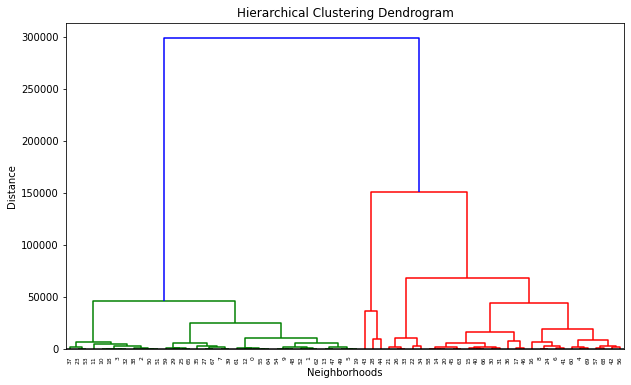

In [142]:
import scipy.cluster.hierarchy as shc

data = milan_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [150]:
milan_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ADRIANO,Italian Restaurant,Supermarket,Park,Bakery,Bistro,Bus Station,Café,Electronics Store,Furniture / Home Store,Hotel
1,AFFORI,Pizza Place,Soccer Field,Park,Hotel,Supermarket,Kebab Restaurant,Skate Park,Shipping Store,Rock Club,Restaurant
2,ASSIANO,NeighborhoodCluster,Airport,Soccer Field,Juice Bar,Mediterranean Restaurant,Food & Drink Shop,Food Court,Food Stand,Food,Falafel Restaurant
3,BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA,NeighborhoodCluster,Pizza Place,Café,Supermarket,Bar,Japanese Restaurant,Plaza,Italian Restaurant,Video Game Store,Filipino Restaurant
4,BANDE NERE,Pizza Place,Café,Italian Restaurant,Plaza,Japanese Restaurant,Supermarket,Hotel,Ice Cream Shop,Restaurant,Cupcake Shop


In [182]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
cluster_result = cluster.fit_predict(data)

milan_grouped['NeighborhoodCluster'] = cluster_result
venues_cluster = df_milan_complete.merge(milan_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster = venues_cluster.merge(milan_venues_sorted[['Neighborhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']])
venues_cluster.head()

,Id,Neighborhood,Borough,Population(31/12/2018) Borough,Latitude,Longitude,NeighborhoodCluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,48,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,6,151 291,45.438460,9.137260,1,Italian Restaurant,Pub,Plaza
1,64,TRENNO,8,188 367,45.492822,9.101675,1,Pizza Place,Soccer Field,Bakery
2,67,PORTELLO,8,188 367,45.484490,9.153947,5,Italian Restaurant,Restaurant,Café
3,81,BOVISASCA,9,187 773,45.517433,9.156731,1,Clothing Store,Italian Restaurant,Park
4,84,PARCO NORD,9,187 773,45.523514,9.184235,1,Soccer Field,Sushi Restaurant,Pub


In [183]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, borough, borough_pop  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Borough'], venues_cluster['Population(31/12/2018) Borough']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(borough) + ' ' + str(borough_pop), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

folium.Marker(milan_center).add_to(map_clusters)
folium.Circle(milan_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(milan_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(milan_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(milan_center, radius=10000, fill=False, color='black').add_to(map_clusters)   
      
map_clusters

In [185]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Venue' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Venue' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                           Neighborhood Count
NeighborhoodCluster 1st Most Common Venue                    
0                   Cocktail Bar                            4
                    Italian Restaurant                      2
1                   Bus Station                             1
                    Bus Stop                                1
                    Café                                    1
                    Clothing Store                          1
                    Fast Food Restaurant                    1
                    Hotel                                   4
                    Italian Restaurant                      9
                    Pizza Place                             3
                    Soccer Field                            2
                    Soccer Stadium                          1
                    Tram Station                            1
2                   Café                                    1
        

Neighborhood Count
NeighborhoodCluster 2nd Most Common Venue                    
0                   Café                                    2
                    Italian Restaurant                      4
1                   Athletics & Sports                      2
                    Bus Station                             1
                    Bus Stop                                1
                    Café                                    3
                    Hotel                                   1
                    Italian Restaurant                      1
                    Metro Station                           1
                    Park                                    2
                    Pizza Place                             3
                    Pub                                     1
                    Seafood Restaurant                      1
                    Shipping Store                          1
                    Soccer Field                            3
                    Supermarket                             3
                    Sushi Restaurant                        1
2                   Café                                    4
                    Chinese Restaurant                      1
                    Cocktail Bar                            2
                    Hotel                                   4
                    Pizza Place                             2
3                   Bakery                                  1
                    Café                                    1
                    Pizza Place                             1
                    Tram Station                            2
4                   Airport                                 1
                    Café                                    1
                    Electronics Store                       1
                    Hotel                                   1
                    Italian Restaurant                      1
                    Pizza Place                             1
                    Restaurant                              1
                    Soccer Field                            2
                    Stables                                 1
                    Tram Station                            2
                    Water Park                              1
5                   Café                                    1
                    Italian Restaurant                      1
                    Pizza Place                             5
                    Plaza                                   2
                    Restaurant                              1
                    Tram Station                            2
                    Wine Bar                                1